# Facial Recognition Project using Siamese Neural Networks

In [17]:
import sys
print(sys.executable)

/home/tamanna/Desktop/CS104_project/Angry-Birds-using-Pygame/venv/bin/python


## Importing Dependencies

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random

# tensorflow dependencies
from keras.models import Sequential, Model
from keras.layers import Layer, Dense, Conv2D, Flatten, Input, MaxPool2D
import tensorflow as tf

2025-10-01 01:13:08.237433: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-01 01:13:08.238546: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-01 01:13:08.337561: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-01 01:13:10.739799: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

## Setting up required files

In [2]:
# setup file paths
pos_path = os.path.join('facial recognition data', 'positive')
neg_path = os.path.join('facial recognition data', 'negative')
anchor_path = os.path.join('facial recognition data', 'anchors')
os.makedirs(pos_path)
os.makedirs(neg_path)
os.makedirs(anchor_path)

In [3]:
# uncompress the image dataset for negatives
# from lfw dataset: http://vis-ww.cs.umass.edu/lfw/

!tar -xf lfw.tgz

In [4]:
# move lfw images to the correct directories

# iterating over all directories in lfw (contains names and each contains certain images of that person)
for directory in os.listdir('lfw'):
  # iterating over all the files in any given person's folder
  for file in os.listdir((os.path.join('lfw', directory))):
    # defining previous path
    prev_path = os.path.join('lfw', directory, file)
    # creating new path
    new_path = os.path.join(neg_path, file)
    # replacing old path by new path, effectively moving the files
    os.replace(prev_path, new_path)

# might seem new, but is actually pretty intuitive and easy

In [5]:
# Import uuid library to generate unique image names for the images we'll create
import uuid

## Creating and storing the dataset

In [7]:
# Create a connection to the webcam
capture = cv2.VideoCapture(0)
while capture.isOpened():
  ret, frame = capture.read()

  # cut frame down to 250x250 pixels
  frame = frame[50:50+250, 200:200+250]

  # collect anchor images
  if cv2.waitKey(1) & 0XFF == ord("a"):
    # create unique file path
    img_name = os.path.join(anchor_path, '{}.jpg'.format(uuid.uuid1()))
    # save image
    cv2.imwrite(img_name, frame)

  # collect positive imagesqq
  if cv2.waitKey(1) & 0XFF == ord("p"):
    # create unique file path
    img_name = os.path.join(pos_path, '{}.jpg'.format(uuid.uuid1()))
    # save image
    cv2.imwrite(img_name, frame)
    
  # show image in screen
  cv2.imshow("Image Collection", frame)
  if cv2.waitKey(1) & 0XFF == ord("q"):
    # waitKey(1) refreshes the window after every millisecond and returns a 32-bit integer
    # we use & to retain only the required 8 digits (0XFF is 11111111) ord() returns unicode and that is within 0-255
    # so pressing q will break
    break

capture.release()
cv2.destroyAllWindows()

## Preprocessing

In [8]:
# with all the data collected, we can begin preprocessing

def preprocess(img_file_path):
    # Read in image from file path
    byte_img = tf.io.read_file(img_file_path)
    # convert the image to a uint8 tensor
    img = tf.io.decode_jpeg(byte_img)

    # resize the image to 100x100
    img = tf.image.resize(img, (100,100))
    # scale the values
    img /= 255
    return img

In [10]:
# get image directories

anchor = tf.data.Dataset.list_files(f"{anchor_path}/*.jpg").take(300)
positive = tf.data.Dataset.list_files(f"{pos_path}/*.jpg").take(300)
negative = tf.data.Dataset.list_files(f"{neg_path}/*.jpg").take(300)

In [11]:
# testing if data is loaded fine or not
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'facial recognition data/anchors/18783c3f-9e37-11f0-80e4-8ce9ee1a47b7.jpg'


In [12]:
# Create labelled dataset
positives = tf.data.Dataset.zip((anchor, positive))
y_positives=tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))
negatives = tf.data.Dataset.zip((anchor, negative))
y_negatives = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))
data = positives.concatenate(negatives)
labels = y_positives.concatenate(y_negatives)

In [13]:
# verify
samples = data.as_numpy_iterator()
print(samples.next())

(b'facial recognition data/anchors/08cec7ef-9e37-11f0-80e0-8ce9ee1a47b7.jpg', b'facial recognition data/positive/46926205-9e37-11f0-b57b-8ce9ee1a47b7.jpg')


In [14]:
# write a new function which does the preeprocessing for a column
def preprocess_twin(t, v):
    return (preprocess(t), preprocess(v))

In [15]:
# pipeline to preprocess the data

data = data.map(preprocess_twin)
dataset = tf.data.Dataset.zip((data, labels))
dataset = dataset.cache()     # to load the files onto a cache for faster access
dataset = dataset.shuffle(buffer_size=1024)

In [16]:
# Partitioning into test and train

# Training Partition
data_train = dataset.take(round(len(data)*0.75))
# Make batches of 16
data_train = data_train.batch(16)
# Preprocess 8 batches while previous ones are being trained
data_train = data_train.prefetch(8)

In [17]:
# Testing Partition
data_test = dataset.skip(round(len(data)*0.75))
data_test = data_test.batch(16)
data_test = data_test.prefetch(8)

## Building the Model

In [18]:
# defining  the distance layer

class L1Dist(Layer):
    def __init__(self, **kwargs):
        # kwargs are there to allow any other parameters such as input_dim, units etc
        # see keras documentation of creating a custom layer
        super().__init__()
    
    # the call function of the class is what the model inhernetly uses
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [19]:
# defining the cnn embeddings

cnn = Sequential([
    Conv2D(filters=64, kernel_size=(10,10), activation='relu', input_shape=(100,100,3)),
    MaxPool2D(64, (2,2), padding='same'),

    Conv2D(filters=128, kernel_size=(7,7), activation='relu'),
    MaxPool2D(64, (2,2), padding='same'),

    Conv2D(filters=128, kernel_size=(4,4), activation='relu'),
    MaxPool2D(64, (2,2), padding='same'),

    Conv2D(filters=256, kernel_size=(4,4), activation='relu'),

    Flatten(),
    Dense(4096, activation='sigmoid')
])

# input for the cnn
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

# creating the siamese layer
distance_layer = L1Dist()
distances = distance_layer(cnn(input_image), cnn(validation_image))

# creating the final layer
output = Dense(1, activation='sigmoid')(distances)

# Defining the model
model = Model(inputs=[input_image, validation_image], outputs=output, name='siameseNetwork')

/home/tamanna/Desktop/CS104_project/Angry-Birds-using-Pygame/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.summary()

Model: "siameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Sequential)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 4096)      │          0 │ sequential[0][0], │
│                     │                   │            │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

## Compiling the Model

In [42]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Training and Testing

In [43]:
model.fit(data_train, batch_size=16, epochs=3, verbose=1)

Epoch 1/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7452 - loss: 0.6681
Epoch 2/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7194 - loss: 0.6678
Epoch 3/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7258 - loss: 0.6638


In [44]:
# accuracy for the test data
loss, accuracy = model.evaluate(data_test)
print(accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 800ms/step - accuracy: 0.7379 - loss: 0.6605
0.737864077091217


In [45]:
model.save("face recog model.h5")

In [46]:
model = tf.keras.models.load_model('face recog model.h5', custom_objects={'L1Dist':L1Dist,  'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

## Visualising Results

In [47]:
run_data = data_test.as_numpy_iterator()

In [48]:
img_input, img_val = run_data.next()[0]
y_hat = model.predict([img_input, img_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step


In [49]:
y_hat

array([[0.53718495],
       [0.53718495],
       [0.53718495],
       [0.53718495],
       [0.53718495],
       [0.53718495],
       [0.53718495],
       [0.53718495],
       [0.53718495],
       [0.53718495],
       [0.53718495],
       [0.53718495],
       [0.53718495],
       [0.53718495],
       [0.53718495],
       [0.53718495]], dtype=float32)

In [50]:
# post-processing
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

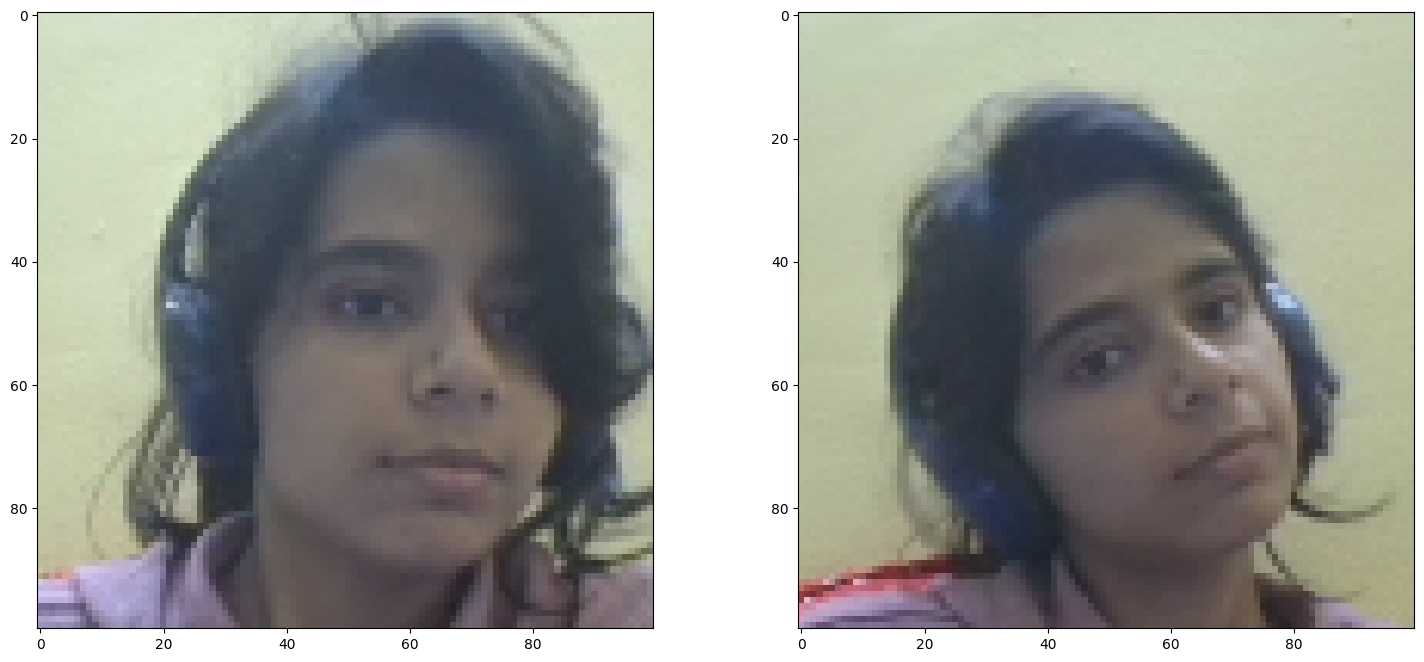

In [51]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(img_input[8])
plt.subplot(1,2,2)
plt.imshow(img_val[8])